### How does the emotional tone of films influence the selection of actor traits, such as age and gender?

In [117]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [43]:
DATA_PATH = '../../data/final_data_complete.csv'
data_df = pd.read_csv(DATA_PATH)
data_df.head()

,WikiID,FreebaseID,Name,ReleaseDate,Runtime,Languages_tuple,Countries_tuples,Genres_tuples,Languages,Countries,...,ActorAge,ActorGender,ActorBirthDate,ActorGenderFlag,merge_title,movieId,title,mean_ratings,std_dev_ratings,count_ratings
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",['English Language'],['United States of America'],...,"[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....","['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...","[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",ghosts of mars,4735.0,Ghosts of Mars (2001),2.427083,1.087064,144.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",['English Language'],['United States of America'],...,"[37.78852253927453, 43.0, 37.78852253927453, 3...","['M', 'F', 'M', 'F', 'M', 'M', 'M', 'F', 'F', ...","[NaT, Timestamp('1956-12-19 00:00:00'), NaT, N...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]",getting away with murder: the jonbenét ramsey ...,NaN,NaN,NaN,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",['Norwegian Language'],['Norway'],...,"[33.0, 28.0, 40.0, 30.0]","['M', 'F', 'M', 'F']","[Timestamp('1954-10-05 00:00:00'), Timestamp('...","[0, 1, 0, 1]",brun bitter,NaN,NaN,NaN,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",['English Language'],['United Kingdom'],...,"[32.0, 26.0]","['M', 'F']","[Timestamp('1954-05-08 00:00:00'), Timestamp('...","[0, 1]",white of the eye,90015.0,White of the Eye (1987),2.250000,2.474874,2.0
4,261236,/m/01mrr1,A Woman in Flames,1983,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",['German Language'],['Germany'],...,"[32.0, 32.0, 35.0]","['F', 'M', 'M']","[Timestamp('1950-06-20 00:00:00'), Timestamp('...","[1, 0, 0]",a woman in flames,NaN,NaN,NaN,NaN,NaN


In [3]:
data_df.dtypes

WikiID                   int64
FreebaseID              object
Name                    object
ReleaseDate             object
Runtime                float64
Languages_tuple         object
Countries_tuples        object
Genres_tuples           object
Languages               object
Countries               object
Genres                  object
Plot                    object
merge_year             float64
nrclex_emotions         object
roberta_emotions        object
distilbert_emotions     object
CharacterName           object
ActorAge                object
ActorGender             object
ActorBirthDate          object
ActorGenderFlag         object
merge_title             object
movieId                float64
title                   object
mean_ratings           float64
std_dev_ratings        float64
count_ratings          float64
dtype: object

First we will simplify the process by filtering for the columns we need for this analysis

In [74]:
# Filter for columns needed for the analysis
character_df = data_df[['WikiID', 'merge_year', 'Genres', 'distilbert_emotions', 'ActorAge', 'ActorGender', 'ActorBirthDate', 'ActorGenderFlag']].copy()
character_df.head()

# Drop rows without emotions because they are not helpful here
print("Number of rows before droping: ", len(character_df))
character_df = character_df.dropna(subset=['distilbert_emotions', 'ActorAge', 'ActorGenderFlag'])
print("Number of rows after droping: ", len(character_df))

Number of rows before droping:  81771
Number of rows after droping:  30175


Let's look closer at our target variables age and gender

In [75]:
test_ages = character_df.iloc[0]['ActorAge']
test_ages

'[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37.78852253927453, 30.0, 37.78852253927453, 37.78852253927453, 42.0, 57.0, 37.78852253927453, 66.0, 47.0, 58.0]'

In [76]:
test_gender = character_df.iloc[0]['ActorGender']
test_gender

"['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F']"

In [77]:
test_gender_flag = character_df.iloc[0]['ActorGenderFlag']
test_gender_flag

'[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]'

The lists with the corresponding values are stored as string, we will parse them first

In [78]:
character_df['Genres'] = character_df['Genres'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorAge'] = character_df['ActorAge'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorGender'] = character_df['ActorGender'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorGenderFlag'] = character_df['ActorGenderFlag'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))

In [79]:
# Lets repeat our test
test_ages = character_df.iloc[0]['ActorAge']
print(test_ages)
test_gender = character_df.iloc[0]['ActorGender']
print(test_gender)
test_gender_flag = character_df.iloc[0]['ActorGenderFlag']
print(test_gender_flag)

[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37.78852253927453, 30.0, 37.78852253927453, 37.78852253927453, 42.0, 57.0, 37.78852253927453, 66.0, 47.0, 58.0]
['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F']
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [80]:
# Is there the same amount of age and gender entries?
print(f"Age entries: {len(test_ages)}, gender entries: {len(test_gender)}, gender flag entries: {len(test_gender_flag)}")

Age entries: 17, gender entries: 17, gender flag entries: 17


We want to do a regression analysis to see if there is a connection between specific emotions and actor age and gender, so we will aggregate the age and the gender flag per movie.

In [81]:
exploded_df = character_df.explode('ActorAge')
exploded_df = exploded_df.explode('ActorGenderFlag')

exploded_df.head()

,WikiID,merge_year,Genres,distilbert_emotions,ActorAge,ActorGender,ActorBirthDate,ActorGenderFlag
0,975900,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...","{'disgust': 0.5021221041679382, 'fear': 0.3510...",42.0,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...",1
0,975900,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...","{'disgust': 0.5021221041679382, 'fear': 0.3510...",42.0,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...",1
0,975900,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...","{'disgust': 0.5021221041679382, 'fear': 0.3510...",42.0,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...",0
0,975900,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...","{'disgust': 0.5021221041679382, 'fear': 0.3510...",42.0,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...",0
0,975900,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...","{'disgust': 0.5021221041679382, 'fear': 0.3510...",42.0,"[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...",1


In [82]:
aggregated_df = exploded_df.groupby('WikiID').agg({
    "ActorAge": "mean",
    "ActorGenderFlag": "mean"
})

aggregated_df.head()

,ActorAge,ActorGenderFlag
WikiID,,
330,48.500000,1.000000
3217,33.898360,0.214286
3333,30.142857,0.428571
3837,45.550000,0.100000
3947,42.876939,0.333333


In [83]:
# Add the calculated variables back to the character dataframe
aggregated_df.rename(columns={
    'ActorAge': 'AgeAvg', 
    'ActorGenderFlag': 'GenderAvg'
}, inplace=True)

character_df = character_df.merge(aggregated_df, on='WikiID', how='left')
character_df.head()

,WikiID,merge_year,Genres,distilbert_emotions,ActorAge,ActorGender,ActorBirthDate,ActorGenderFlag,AgeAvg,GenderAvg
0,975900,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...","{'disgust': 0.5021221041679382, 'fear': 0.3510...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....","[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...","[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.126711,0.352941
1,9363483,1987.0,"[Thriller, Erotic thriller, Psychological thri...","{'anger': 0.5024036765098572, 'disgust': 0.324...","[32.0, 26.0]","[M, F]","[Timestamp('1954-05-08 00:00:00'), Timestamp('...","[0, 1]",29.000000,0.500000
2,261236,1983.0,[Drama],"{'anger': 0.3256497378461063, 'disgust': 0.163...","[32.0, 32.0, 35.0]","[F, M, M]","[Timestamp('1950-06-20 00:00:00'), Timestamp('...","[1, 0, 0]",33.000000,0.333333
3,6631279,1997.0,"[Romantic comedy, Ensemble Film, Comedy-drama,...","{'sadness': 0.9155038595199585, 'neutral': 0.0...","[25.0, 33.0, 37.0, 35.0, 33.0, 48.0]","[M, F, F, M, F, F]","[Timestamp('1971-09-15 00:00:00'), Timestamp('...","[0, 1, 1, 0, 1, 1]",35.166667,0.666667
4,171005,1989.0,"[Costume drama, War film, Epic, Period piece, ...","{'neutral': 0.6794102787971497, 'surprise': 0....","[28.0, 51.0, 33.0, 26.0, 30.0, 32.0, 58.0, 53....","[M, M, M, M, F, M, M, M, M, M, F, M, M, F, M, ...","[Timestamp('1960-12-10 00:00:00'), Timestamp('...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",45.513739,0.190476


After we filtered for the necessary data let's check the core of this analysis, the distilbert emotion column

In [84]:
test_emotions = character_df.iloc[0]['distilbert_emotions']
print(type(test_emotions))
test_emotions

<class 'str'>


"{'disgust': 0.5021221041679382, 'fear': 0.35102203488349915, 'anger': 0.06514739245176315, 'neutral': 0.05708540976047516, 'sadness': 0.01877124048769474, 'surprise': 0.004085681866854429, 'joy': 0.0017661249730736017}"

It seems that the emotion dictionary is also saved as string, lets fix that

In [85]:
character_df['distilbert_emotions'] = character_df['distilbert_emotions'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

# Check the result
test_emotions = character_df.iloc[0]['distilbert_emotions']
print(type(test_emotions))
test_emotions

<class 'dict'>


{'disgust': 0.5021221041679382,
 'fear': 0.35102203488349915,
 'anger': 0.06514739245176315,
 'neutral': 0.05708540976047516,
 'sadness': 0.01877124048769474,
 'surprise': 0.004085681866854429,
 'joy': 0.0017661249730736017}

Now that we fixed the column we will create a column for each emotion to conduct the analysis.

In [86]:
test_emotions = character_df.iloc[0]['distilbert_emotions']['disgust']
test_emotions

0.5021221041679382

In [87]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
for emotion in emotions:
    character_df[emotion] = character_df['distilbert_emotions'].apply(lambda x: x[emotion])
character_df.head()

,WikiID,merge_year,Genres,distilbert_emotions,ActorAge,ActorGender,ActorBirthDate,ActorGenderFlag,AgeAvg,GenderAvg,disgust,fear,anger,neutral,sadness,surprise,joy
0,975900,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...","{'disgust': 0.5021221041679382, 'fear': 0.3510...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....","[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...","[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.126711,0.352941,0.502122,0.351022,0.065147,0.057085,0.018771,0.004086,0.001766
1,9363483,1987.0,"[Thriller, Erotic thriller, Psychological thri...","{'anger': 0.5024036765098572, 'disgust': 0.324...","[32.0, 26.0]","[M, F]","[Timestamp('1954-05-08 00:00:00'), Timestamp('...","[0, 1]",29.000000,0.500000,0.324022,0.032032,0.502404,0.096385,0.037811,0.005438,0.001907
2,261236,1983.0,[Drama],"{'anger': 0.3256497378461063, 'disgust': 0.163...","[32.0, 32.0, 35.0]","[F, M, M]","[Timestamp('1950-06-20 00:00:00'), Timestamp('...","[1, 0, 0]",33.000000,0.333333,0.163747,0.002405,0.325650,0.440068,0.025255,0.005851,0.037024
3,6631279,1997.0,"[Romantic comedy, Ensemble Film, Comedy-drama,...","{'sadness': 0.9155038595199585, 'neutral': 0.0...","[25.0, 33.0, 37.0, 35.0, 33.0, 48.0]","[M, F, F, M, F, F]","[Timestamp('1971-09-15 00:00:00'), Timestamp('...","[0, 1, 1, 0, 1, 1]",35.166667,0.666667,0.021709,0.010488,0.006082,0.042634,0.915504,0.002163,0.001421
4,171005,1989.0,"[Costume drama, War film, Epic, Period piece, ...","{'neutral': 0.6794102787971497, 'surprise': 0....","[28.0, 51.0, 33.0, 26.0, 30.0, 32.0, 58.0, 53....","[M, M, M, M, F, M, M, M, M, M, F, M, M, F, M, ...","[Timestamp('1960-12-10 00:00:00'), Timestamp('...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",45.513739,0.190476,0.004746,0.003841,0.016094,0.679410,0.057925,0.129912,0.108072


To make the influence of different emotions comparable between each other we have to standardize the values column wise:

In [88]:
# Use standard scaler from sklearn and do fit and transform
scaler = StandardScaler()
character_df[emotions] = scaler.fit_transform(character_df[emotions])

# Check the results
character_df.head()

,WikiID,merge_year,Genres,distilbert_emotions,ActorAge,ActorGender,ActorBirthDate,ActorGenderFlag,AgeAvg,GenderAvg,disgust,fear,anger,neutral,sadness,surprise,joy
0,975900,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...","{'disgust': 0.5021221041679382, 'fear': 0.3510...","[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....","[F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...","[Timestamp('1958-08-26 00:00:00'), Timestamp('...","[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.126711,0.352941,1.548388,0.857599,-0.605978,-0.721262,-0.626891,-0.365018,-0.349031
1,9363483,1987.0,"[Thriller, Erotic thriller, Psychological thri...","{'anger': 0.5024036765098572, 'disgust': 0.324...","[32.0, 26.0]","[M, F]","[Timestamp('1954-05-08 00:00:00'), Timestamp('...","[0, 1]",29.000000,0.500000,0.701957,-0.509468,1.296353,-0.538560,-0.545473,-0.353589,-0.347850
2,261236,1983.0,[Drama],"{'anger': 0.3256497378461063, 'disgust': 0.163...","[32.0, 32.0, 35.0]","[F, M, M]","[Timestamp('1950-06-20 00:00:00'), Timestamp('...","[1, 0, 0]",33.000000,0.333333,-0.059764,-0.636439,0.527366,1.059187,-0.599163,-0.350103,-0.053742
3,6631279,1997.0,"[Romantic comedy, Ensemble Film, Comedy-drama,...","{'sadness': 0.9155038595199585, 'neutral': 0.0...","[25.0, 33.0, 37.0, 35.0, 33.0, 48.0]","[M, F, F, M, F, F]","[Timestamp('1971-09-15 00:00:00'), Timestamp('...","[0, 1, 1, 0, 1, 1]",35.166667,0.666667,-0.734809,-0.601797,-0.862948,-0.788447,3.207756,-0.381261,-0.351924
4,171005,1989.0,"[Costume drama, War film, Epic, Period piece, ...","{'neutral': 0.6794102787971497, 'surprise': 0....","[28.0, 51.0, 33.0, 26.0, 30.0, 32.0, 58.0, 53....","[M, M, M, M, F, M, M, M, M, M, F, M, M, F, M, ...","[Timestamp('1960-12-10 00:00:00'), Timestamp('...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",45.513739,0.190476,-0.815427,-0.630285,-0.819388,2.171864,-0.459461,0.698016,0.541288


Now lets start the analyis, first we will have a look of the influence of each single emotion on the age average of actors as well as the gender average. To determine if a predictor is significant we will use a significance level of 0.95 resulting in alpha=0.05.

In [89]:
# Set random seed for reproducability
np.random.seed(2)

#### Disgust

In [90]:
disgust_age_mod = smf.ols(formula='AgeAvg ~ disgust', data=character_df)
disgust_age_res = disgust_age_mod.fit()
print(disgust_age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.374
Date:                Sun, 15 Dec 2024   Prob (F-statistic):            0.00662
Time:                        18:10:12   Log-Likelihood:            -1.0086e+05
No. Observations:               30175   AIC:                         2.017e+05
Df Residuals:                   30173   BIC:                         2.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8041      0.039    959.432      0.0

In [91]:
disgust_gender_mod = smf.ols(formula='GenderAvg ~ disgust', data=character_df)
disgust_gender_res = disgust_gender_mod.fit()
print(disgust_gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.606
Date:                Sun, 15 Dec 2024   Prob (F-statistic):              0.106
Time:                        18:10:13   Log-Likelihood:                 2882.1
No. Observations:               30175   AIC:                            -5760.
Df Residuals:                   30173   BIC:                            -5744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3384      0.001    267.241      0.0

We can see that the emotion disgust is a significant predictor for the average age of involved actors but not for the average gender of involved actors. Disgust has a negative impact on the average age of involved actors, with an intercept of 37.8 and a coefficient of ~ -0.1. That means that in movies where disgust is a predominant emotion, younger actors are preferred.

#### Fear

In [92]:
fear_age_mod = smf.ols(formula='AgeAvg ~ fear', data=character_df)
fear_age_res = fear_age_mod.fit()
print(fear_age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.73
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.79e-08
Time:                        18:10:14   Log-Likelihood:            -1.0084e+05
No. Observations:               30175   AIC:                         2.017e+05
Df Residuals:                   30173   BIC:                         2.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8041      0.039    959.819      0.0

In [93]:
fear_gender_mod = smf.ols(formula='GenderAvg ~ fear', data=character_df)
fear_gender_res = fear_gender_mod.fit()
print(fear_gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.802
Date:                Sun, 15 Dec 2024   Prob (F-statistic):             0.0512
Time:                        18:10:17   Log-Likelihood:                 2882.7
No. Observations:               30175   AIC:                            -5761.
Df Residuals:                   30173   BIC:                            -5745.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3384      0.001    267.246      0.0

We can see that fear is a significant predictor for the average age of involved actors but not for the average gender of involved actors. Fear has a positive impact on the average age of involved actors with an intercept of 37.8 and a coefficient of ~ 0.22. That means that in movies where fear is a dominant emotion, older actors are preferred.

#### Anger

In [94]:
anger_age_mod = smf.ols(formula='AgeAvg ~ anger', data=character_df)
anger_age_res = anger_age_mod.fit()
print(anger_age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 4.023e-05
Date:                Sun, 15 Dec 2024   Prob (F-statistic):              0.995
Time:                        18:10:31   Log-Likelihood:            -1.0086e+05
No. Observations:               30175   AIC:                         2.017e+05
Df Residuals:                   30173   BIC:                         2.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8041      0.039    959.315      0.0

In [95]:
anger_gender_mod = smf.ols(formula='GenderAvg ~ anger', data=character_df)
anger_gender_res = anger_gender_mod.fit()
print(anger_gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     256.1
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           2.14e-57
Time:                        18:10:31   Log-Likelihood:                 3008.3
No. Observations:               30175   AIC:                            -6013.
Df Residuals:                   30173   BIC:                            -5996.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3384      0.001    268.361      0.0

For anger we have a different picture. Anger is not a significant predictor for the average age of involved actors but for the average gender of involved actors. It has a negative impact on the percentage of female actors with an intercept of ~ 0.33 and a coefficient of -0.02. That means for movies where anger is a dominant emotion male actors are preferred.

#### Neutral

In [96]:
neutral_age_mod = smf.ols(formula='AgeAvg ~ neutral', data=character_df)
neutral_age_res = neutral_age_mod.fit()
print(neutral_age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.28
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.91e-05
Time:                        18:10:35   Log-Likelihood:            -1.0085e+05
No. Observations:               30175   AIC:                         2.017e+05
Df Residuals:                   30173   BIC:                         2.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8041      0.039    959.605      0.0

In [97]:
neutral_gender_mod = smf.ols(formula='GenderAvg ~ neutral', data=character_df)
neutral_gender_res = neutral_gender_mod.fit()
print(neutral_gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     23.05
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.59e-06
Time:                        18:10:35   Log-Likelihood:                 2892.3
No. Observations:               30175   AIC:                            -5781.
Df Residuals:                   30173   BIC:                            -5764.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3384      0.001    267.331      0.0

The emotion neutral is a significant predictor for both average age and gender of involved actors. It has a positive impact on the average actor age with an intercept of ~ 37.8 and a coefficient of 0.17, meaning that in movies where neutral is a dominant emotion older actors are preferred. For the average gender on the other hand there is a very small negative impact with an intercept of ~ 0.33 and a coefficient of -0.0063, meaning that for movies where neutral is a dominant emotion male actors are preferred. Here it has to be noticed, that the influence is significant but very small.

#### Sadness

In [98]:
sad_age_mod = smf.ols(formula='AgeAvg ~ sadness', data=character_df)
sad_age_res = sad_age_mod.fit()
print(sad_age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.27
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           2.27e-08
Time:                        18:10:40   Log-Likelihood:            -1.0084e+05
No. Observations:               30175   AIC:                         2.017e+05
Df Residuals:                   30173   BIC:                         2.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8041      0.039    959.811      0.0

In [99]:
sad_gender_mod = smf.ols(formula='GenderAvg ~ sadness', data=character_df)
sad_gender_res = sad_gender_mod.fit()
print(sad_gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     272.1
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           7.25e-61
Time:                        18:10:43   Log-Likelihood:                 3016.3
No. Observations:               30175   AIC:                            -6029.
Df Residuals:                   30173   BIC:                            -6012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3384      0.001    268.431      0.0

Sadness is a significant predictor for both average age and gender of involved actors. It has a negative impact on the average age of actors with a coefficient of -0.22 and a positive impact on the percentage of femal actors with a coefficient of 0.02. That means that in movies where sadness is a dominant emotion, younger and female actors are preferred.

#### Surprise

In [100]:
sur_age_mod = smf.ols(formula='AgeAvg ~ surprise', data=character_df)
sur_age_res = sur_age_mod.fit()
print(sur_age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4193
Date:                Sun, 15 Dec 2024   Prob (F-statistic):              0.517
Time:                        18:11:05   Log-Likelihood:            -1.0086e+05
No. Observations:               30175   AIC:                         2.017e+05
Df Residuals:                   30173   BIC:                         2.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8041      0.039    959.321      0.0

In [101]:
sur_gender_mod = smf.ols(formula='GenderAvg ~ surprise', data=character_df)
sur_gender_res = sur_gender_mod.fit()
print(sur_gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     23.77
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           1.09e-06
Time:                        18:11:06   Log-Likelihood:                 2892.7
No. Observations:               30175   AIC:                            -5781.
Df Residuals:                   30173   BIC:                            -5765.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3384      0.001    267.334      0.0

Surprise is not a significant predictor for the average age of involved actors but for the average gender. With a coefficient of 0.0061 it has a slightly positive impact on the percentage of female actors in movies, indicating that in movies where surprise is a dominant emotion, female actors are preferred.

#### Joy

In [102]:
joy_age_mod = smf.ols(formula='AgeAvg ~ joy', data=character_df)
joy_age_res = joy_age_mod.fit()
print(joy_age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     12.98
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           0.000315
Time:                        18:11:08   Log-Likelihood:            -1.0085e+05
No. Observations:               30175   AIC:                         2.017e+05
Df Residuals:                   30173   BIC:                         2.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8041      0.039    959.521      0.0

In [103]:
joy_gender_mod = smf.ols(formula='GenderAvg ~ joy', data=character_df)
joy_gender_res = joy_gender_mod.fit()
print(joy_gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     80.87
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           2.55e-19
Time:                        18:11:09   Log-Likelihood:                 2921.2
No. Observations:               30175   AIC:                            -5838.
Df Residuals:                   30173   BIC:                            -5822.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3384      0.001    267.587      0.0

Joy is a significant predictor for both the average age and the average gender of involved actors. With a coefficient of -0.14 it has a negative impact on the average age of involved actors indicating that in movies where joy is a dominant emotion, older actors are preferred. With a coefficient of 0.01 it has a positive impact on the percentage of female actors, so in movies where joy is a dominant emotion, female actors are preferred.

### First summary

Overall we can see, that different emotions can be a significant predictor for the average age and gender of involved actors. That is particularly interesting to understand casting decisions and can be helpful for actors to decide for which movies they should do an audition. Now lets see if we can fit a model including all the emotions to get a more complete picture of how emotions influence age and gender of involved actors.

#### Complete model for average age

In [104]:
emotions

['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']

In [105]:
age_mod = smf.ols(formula='AgeAvg ~ disgust + fear + anger + neutral + sadness + surprise + joy', data=character_df)
age_res = age_mod.fit()
print(age_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 AgeAvg   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     13.16
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           4.80e-17
Time:                        18:11:14   Log-Likelihood:            -1.0081e+05
No. Observations:               30175   AIC:                         2.016e+05
Df Residuals:                   30167   BIC:                         2.017e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.8041      0.039    960.683      0.0

In [106]:
gender_mod = smf.ols(formula='GenderAvg ~ disgust + fear + anger + neutral + sadness + surprise + joy', data=character_df)
gender_res = gender_mod.fit()
print(gender_res.summary())

                            OLS Regression Results                            
Dep. Variable:              GenderAvg   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     76.85
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.59e-111
Time:                        18:11:24   Log-Likelihood:                 3147.5
No. Observations:               30175   AIC:                            -6279.
Df Residuals:                   30167   BIC:                            -6212.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3384      0.001    269.575      0.0

It seems that when combined no emotion is a significant predictor, likely because of multicolinarity. So lets check that

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
emotion_df = character_df[['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']]
vif_data = pd.DataFrame()
vif_data["Variable"] = emotion_df.columns
vif_data["VIF"] = [variance_inflation_factor(emotion_df.values, i) for i in range(emotion_df.shape[1])]

print(vif_data)

   Variable           VIF
0   disgust  1.735491e+13
1      fear  2.134407e+13
2     anger  2.070621e+13
3   neutral  1.812314e+13
4   sadness  2.139477e+13
5  surprise  5.485505e+12
6       joy  5.584128e+12


In [108]:
correlation_matrix = character_df[['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']].corr()
print(correlation_matrix)

           disgust      fear     anger   neutral   sadness  surprise       joy
disgust   1.000000 -0.224354 -0.055964 -0.211494 -0.242464 -0.185363 -0.176413
fear     -0.224354  1.000000 -0.206568 -0.268345 -0.234403 -0.056546 -0.162655
anger    -0.055964 -0.206568  1.000000 -0.291715 -0.273985 -0.157576 -0.204393
neutral  -0.211494 -0.268345 -0.291715  1.000000 -0.210060 -0.032004  0.100285
sadness  -0.242464 -0.234403 -0.273985 -0.210060  1.000000 -0.092891 -0.075215
surprise -0.185363 -0.056546 -0.157576 -0.032004 -0.092891  1.000000 -0.011244
joy      -0.176413 -0.162655 -0.204393  0.100285 -0.075215 -0.011244  1.000000


Event though the pairwise correlations between the emotions are not too high, the very high VIF values indicate that there is some kind of multicoliniarity between them. We try to overcome this by using regularization

In [ ]:
# Define predictors and target
X = character_df[['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']]
actor_y = character_df['AgeAvg']

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X, actor_y)

# Create a dataframe for better visualization
actor_coefficients_df = pd.DataFrame({
    'Emotion': ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'],
    'Ridge Coefficient': ridge.coef_
})

actor_coefficients_df

,Emotion,Ridge Coefficient
0,disgust,-0.099118
1,fear,0.180371
2,anger,0.002660
3,neutral,0.175966
4,sadness,-0.175872
5,surprise,0.005256
6,joy,-0.160355


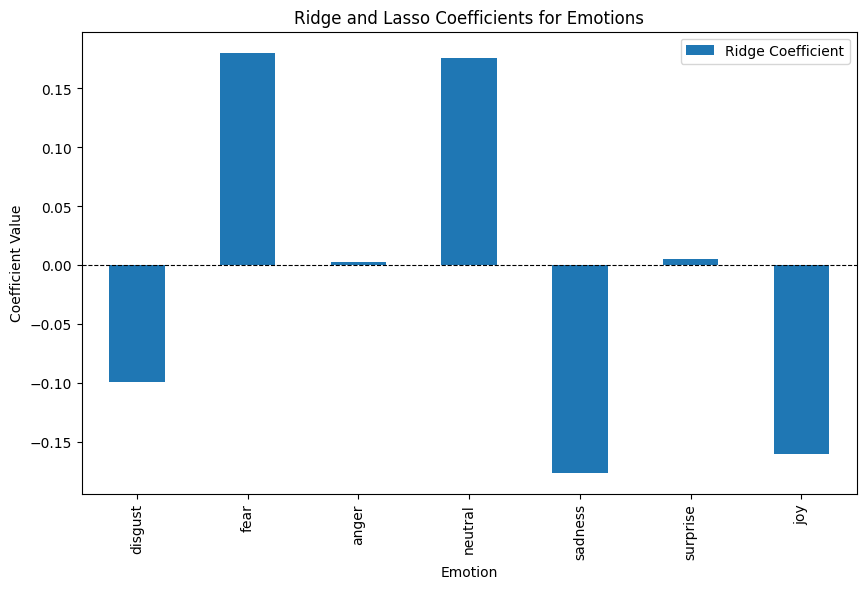

In [ ]:
# Plot the results
actor_coefficients_df.set_index('Emotion').plot(kind='bar', figsize=(10, 6))
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('Coefficient Value')
plt.title('Ridge Coefficients for Emotions on Average Actor Age')
plt.show()

In [115]:
# Define predictors and target
X = character_df[['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']]
gender_y = character_df['GenderAvg']

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X, gender_y)

# Create a dataframe for better visualization
gender_coefficients_df = pd.DataFrame({
    'Emotion': ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'],
    'Ridge Coefficient': ridge.coef_
})

gender_coefficients_df

,Emotion,Ridge Coefficient
0,disgust,0.001484
1,fear,-0.001946
2,anger,-0.015681
3,neutral,-0.008379
4,sadness,0.015889
5,surprise,0.005187
6,joy,0.010205


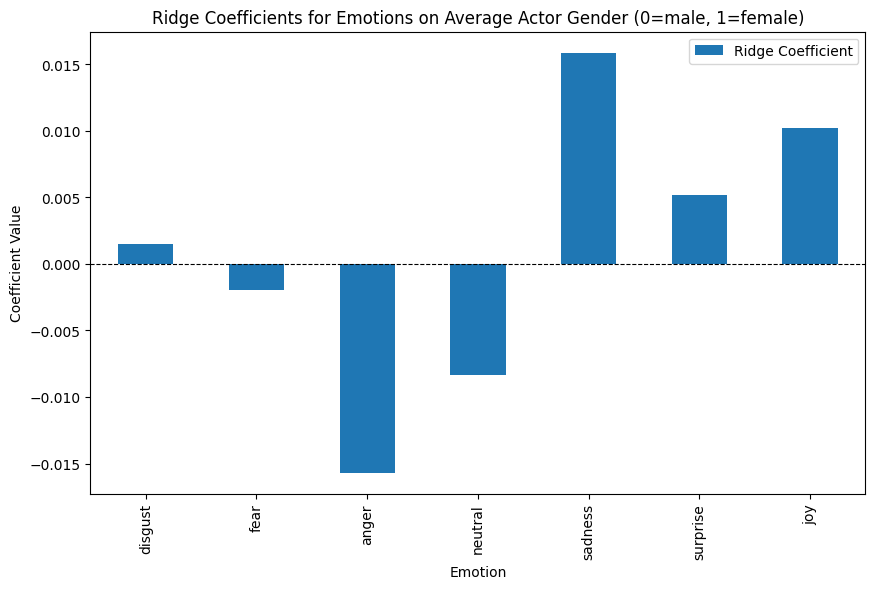

In [116]:
# Plot the results
gender_coefficients_df.set_index('Emotion').plot(kind='bar', figsize=(10, 6))
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('Coefficient Value')
plt.title('Ridge Coefficients for Emotions on Average Actor Gender (0=male, 1=female)')
plt.show()

With ridge regression we get better results, but we can't be sure that the emotions are significant predictors. Therefore we will use bootstraping to obtain confidence intervalls for the coefficients.

In [ ]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000
ridge_coefs = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    X_resample, y_resample = resample(X, y)
    
    # Ridge
    ridge.fit(X_resample, y_resample)
    ridge_coefs.append(ridge.coef_)

# Convert results to arrays
ridge_coefs = np.array(ridge_coefs)

# Calculate confidence intervals (e.g., 2.5% and 97.5%)
ridge_ci = np.percentile(ridge_coefs, [2.5, 97.5], axis=0)

print("Ridge coefficient confidence intervals for actor age:", ridge_ci)

age_coefficients_CI_df = pd.DataFrame({
    'Emotion': ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'],
    'Lower bound': ridge_ci[0],
    'Upper bound': ridge_ci[1]
})

age_coefficients_CI_df

Ridge coefficient confidence intervals for actor age: [[-0.16415506  0.11608728 -0.05719859  0.09539849 -0.23818762 -0.07298678
  -0.24187866]
 [-0.02721493  0.24021296  0.06144632  0.25329069 -0.11159101  0.08192203
  -0.07946062]]


,Emotion,Lower bound,Upper bound
0,disgust,-0.164155,-0.027215
1,fear,0.116087,0.240213
2,anger,-0.057199,0.061446
3,neutral,0.095398,0.253291
4,sadness,-0.238188,-0.111591
5,surprise,-0.072987,0.081922
6,joy,-0.241879,-0.079461


We can say that a coefficient is significant if the 95% confidence interval does not include 0. So we can see that all emotions except anger and surprise are significant.

In [123]:
# Number of bootstrap samples
n_bootstraps = 1000
ridge_coefs = []

# Bootstrap resampling
for _ in range(n_bootstraps):
    X_resample, y_resample = resample(X, gender_y)
    
    # Ridge
    ridge.fit(X_resample, y_resample)
    ridge_coefs.append(ridge.coef_)

# Convert results to arrays
ridge_coefs = np.array(ridge_coefs)

# Calculate confidence intervals (e.g., 2.5% and 97.5%)
ridge_ci = np.percentile(ridge_coefs, [2.5, 97.5], axis=0)

print("Ridge coefficient confidence intervals for actor gender:", ridge_ci)

gender_coefficients_CI_df = pd.DataFrame({
    'Emotion': ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'],
    'Lower bound': ridge_ci[0],
    'Upper bound': ridge_ci[1]
})

gender_coefficients_CI_df

Ridge coefficient confidence intervals for actor gender: [[-0.00078063 -0.00402874 -0.01771486 -0.01057496  0.01400161  0.00283955
   0.00741963]
 [ 0.00358169  0.00012747 -0.01367544 -0.00613328  0.01799326  0.00755117
   0.01299083]]


,Emotion,Lower bound,Upper bound
0,disgust,-0.000781,0.003582
1,fear,-0.004029,0.000127
2,anger,-0.017715,-0.013675
3,neutral,-0.010575,-0.006133
4,sadness,0.014002,0.017993
5,surprise,0.002840,0.007551
6,joy,0.007420,0.012991


Again, a coefficient is significant if its confidence interval does not includes 0. So we can see that for the gender of actors all emotions except disgust and fear are significant predictors.

With ridge regression we get better results. We can see that disgust, sadness and joy have a negative coefficient for the average age of involved actors, which means that in movies where these emotions are dominant, the involved actors tend to be younger. Anger and surprise seem to have not a big impact and fear and neutral have a positive impact, meaning that in movies where these emotions are dominant involved actors tend to be older.